8.81162974186
10.840948323


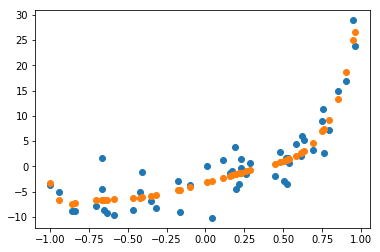

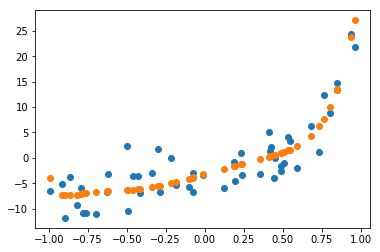

In [186]:
#question 1
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import vander
from numpy.linalg import inv


#load data from the csv files and generate the matrices
def data_loader(key, n):
    data=np.genfromtxt('Dataset_' + str(n)+'_' + key + '.csv', delimiter=',')
    x=data[:, 0]
    y=data[:, 1]
    return x, y

#take actual y and y predicted
#subtract the difference (add all of this up over the vector)
#square it
#divide over total
def mse(y_actual, y_predicted):
    #take the difference between the predicted y and actual y
    diff=np.subtract(y_predicted, y_actual)
    sum=0
    #add the squares of the differences up
    for element in diff:
        sum+=(element)*(element)
    #return the average of this sum
    return sum/len(y_actual)


# ŵ = (X^TX)-1 XT Y
def linear_regression(x, y, lmda=0):
    #here we take the transpose of the matrix
    transposed_x=x.transpose()
    #we can then calculate X^TX
    xtx=np.matmul(transposed_x, x)
    #ridge regression ŵridge = (X^TX+λI)^-1(X^TY)
    l2=np.add(xtx, np.identity(len(xtx))*lmda)
    inv_xtx=inv(l2)
    xty=np.matmul(transposed_x, y)
    w = np.matmul(inv_xtx, xty)
    return w

def predict(p, key, n, number):
    x, y = data_loader(key, number)
    y_predicted = p(x)
    err=mse(y, y_predicted)
    #print "The MSE for " + key + " is " + str(err)
    plt.figure(n)
    plt.plot(x, y, 'o')
    plt.plot(x, y_predicted, 'o')
    return err
    
def plot_regression(test, order, figure_number, lmda=0):
    #load data based on train, test, or valid
    x, y = data_loader('train', 1)
    #turn x into a vander matrix of whatever order we like, in this case 20
    matrix=vander(x, order)
    #get the weights
    w=linear_regression(matrix, y, lmda)
    #create a polynomial of the weights
    f = np.poly1d(w)
    y_predicted=f(x)
    train_err=predict(f, 'train', figure_number, 1)
    if test==True:
        test_err=predict(f, 'test', figure_number+1, 1)
        return train_err, test_err
    else:
        valid_err=predict(f, 'valid', figure_number+1, 1)
        return train_err, valid_err

def optimal_lmbda(order):
    mse={}
    for i in np.arange(0.0, 1.0, 0.001):
        mse[i]=plot_regression(False, order, i)
    avg_mse={}
    for item in mse:
        avg_mse[item]=(mse[item][0]+mse[item][1])/2
    sorted_mse=[]
    for key, value in sorted(avg_mse.iteritems(), key=lambda (k,v): (v,k)):
        sorted_mse.append(key)
    optimal=sorted_mse[0]
    return mse, mse[optimal], optimal

def plot_lmbda(order):
    mse, optimal, l = optimal_lmbda(20)
    lmbda=[]
    train_mse=[]
    valid_mse=[]
    for element in mse:
        lmbda.append(element)
        train_mse.append(mse[element][0])
        valid_mse.append(mse[element][1])
        
    plt.figure(5)
    plt.ylim(0, 10)
    plt.plot(lmbda, train_mse, 'o')
    plt.plot(lmbda, valid_mse, 'o')
    print l
        
#train_err, valid_err=plot_regression(False, 20, 1, 0)
#print train_err
#print valid_err
#plot_regression(False, 20, 3, 0.01)
#plot_regression(False, 20, 5, 0.1)
#plot_regression(False, 20, 7, 0.09)
train_err, test_err=plot_regression(True, 20, 9, 0.01)
print train_err
print test_err

3.61829601168
3.61826733743
3.61821687402
3.61818332975
3.61813316037


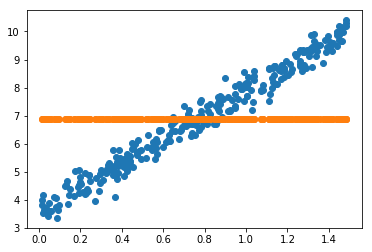

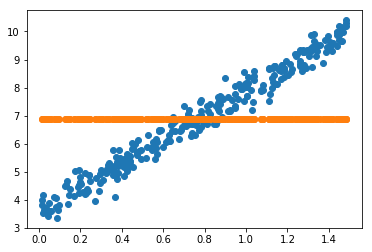

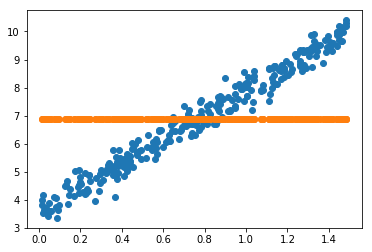

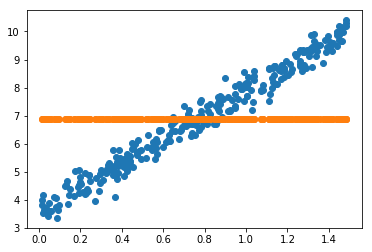

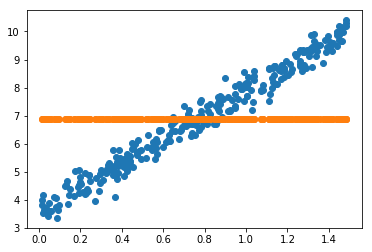

In [19]:
#question 2
#Fit a linear regression model to this dataset by using stochastic gradient descent. You
#will do online-SGD (with one example at a time). Use the step size of 1e-6. Compute
#the MSE on validation set for every epoch. Plot the learning curve i.e. training and
#validation MSE for every epoch.
#2(XTXw – XTY)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import vander
from numpy.linalg import inv

#load data from the csv files and generate the matrices
def data_loader(key, n):
    data=np.genfromtxt('Dataset_' + str(n)+'_' + key + '.csv', delimiter=',')
    x=data[:, 0]
    y=data[:, 1]
    return x, y

#take actual y and y predicted
#subtract the difference (add all of this up over the vector)
#square it
#divide over total
def mse(y_actual, y_predicted):
    #take the difference between the predicted y and actual y
    diff=np.subtract(y_predicted, y_actual)
    sum=0
    #add the squares of the differences up
    for element in diff:
        sum+=(element)*(element)
    #return the average of this sum
    return sum/len(y_actual)


# ŵ = (X^TX)-1 XT Y
def linear_regression(x, y, lmda=0):
    #here we take the transpose of the matrix
    transposed_x=x.transpose()
    #we can then calculate X^TX
    xtx=np.matmul(transposed_x, x)
    #ridge regression ŵridge = (X^TX+λI)^-1(X^TY)
    l2=np.add(xtx, np.identity(len(xtx))*lmda)
    inv_xtx=inv(l2)
    xty=np.matmul(transposed_x, y)
    w = np.matmul(inv_xtx, xty)
    return w

def predict(p, key, n, number):
    x, y = data_loader(key, number)
    y_predicted = p(x)
    err=mse(y, y_predicted)
    #print "The MSE for " + key + " is " + str(err)
    #plt.figure(n)
    #plt.plot(x, y, 'o')
    #plt.plot(x, y_predicted, 'o')
    return err


def derivative_error(x, y, w):
    transposed_x=x.transpose()
    xtx=np.matmul(transposed_x, x)
    xty=np.matmul(transposed_x, y)
    xtxw=np.matmul(xtx, w)
    subtracted=np.subtract(xtxw, xty)
    return 2*subtracted


def sgd(order, epochs, learning_step, figure_number):
    #get initial weights
    x, y = data_loader('train', 2)
    matrix=vander(x, order)
    w=linear_regression(matrix, y, 0)
    #valid_error=[]
    #training_error=[]
    valid_err=0
    err=0
    
    #subtract learning curve times derivative of error
    for i in range(0, epochs):
        f = np.poly1d(w)
        y_predicted=f(x)
        err= mse(y, y_predicted)
        #training_error.append(err)
        valid_err=predict(f, 'test', 1, 2)
        #valid_error.append(valid_err)
        step=learning_step*derivative_error(matrix, y, w)
        w=w-learning_step
    #return (err+valid_err)/2
    #x=range(0,100)
    #plt.figure(2)
    #plt.ylim(0, 10)
    #plt.plot(x, training_error, 'o')
    plt.figure(figure_number)
    #plt.plot(x, valid_err, 'o')
    f = np.poly1d(w)
    predicted=f(x)
    plt.plot(x, y, 'o' )
    plt.plot(x, y_predicted, 'o' )
    return valid_err
    
def step_test(order, epochs, r):
    avg_mse={}
    for i in np.arange(1e-6, r, 1e-7):
        print i
        avg_mse[i]=(sgd(order, epochs, i))
    for key, value in sorted(avg_mse.iteritems(), key=lambda (k,v): (v,k)):
        print "%s: %s" % (key, value)
    
    
#sgd(1, 100, 1e-6)
#step_test(1, 20, 1e-5)
error1=sgd(1, 3, 9.9e-6, 1)
print error1
error2=sgd(1, 20, 9.9e-6, 2)
print error2
error3=sgd(1, 50, 9.9e-6, 3)
print error3
error4=sgd(1, 70, 9.9e-6, 4)
print error4
error5=sgd(1, 100, 9.9e-6, 5)
print error5

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
import matplotlib.pyplot as plt
import math
from numpy.linalg import inv

def filler():
    data=pd.read_csv('communities.csv', delimiter=',', header=None, na_values='?')
    sums = data.sum().fillna(0)
    nulls = data.isnull().sum()
    for x in range(0, 127):
        summed = sums[x]
        sample_number = 1993-nulls[x]
        sample_mean = summed/sample_number
        data[x]=data[x].fillna(sample_mean)
    data.to_csv('communities_filled.csv', header=False, index=False)
    
def splitter(path, n):
    to_split=pd.read_csv(path, header=None)
    train = to_split.sample(frac=0.8, random_state=RandomState())
    test = to_split.loc[~data.index.isin(train.index)]
    train.to_csv('CandC-train<' + str(n) + '>.csv', header=False, index=False)
    test.to_csv('CandC-test<' + str(n) + '>.csv', header=False, index=False)
    
def split():
    for x in range (1, 6):
        splitter('communities_filled.csv', x)
    print "completed splitting"
    
#split()
#goal attribute is the last column

def load_matrices(n, train_or_test):
    data=np.genfromtxt('CandC-' + str(train_or_test) + '<' + str(n)+'>.csv', delimiter=',')
    x=data[:,:-1]
    y=data[:,-1:]
    return x,y

def linear_regression(x, y, lmda=0):
    #here we take the transpose of the matrix
    transposed_x=x.transpose()
    #we can then calculate X^TX
    xtx=np.matmul(transposed_x, x)
    #ridge regression ŵridge = (X^TX+λI)^-1(X^TY)
    l2=np.add(xtx, np.identity(len(xtx))*lmda)
    inv_xtx=inv(l2)
    xty=np.matmul(transposed_x, y)
    w = np.matmul(inv_xtx, xty)
    return w

def mse(y_actual, y_predicted):
    #take the difference between the predicted y and actual y
    diff=np.subtract(y_predicted, y_actual)
    sum=0
    #add the squares of the differences up
    for element in diff:
        sum+=(element)*(element)
    #return the average of this sum
    return sum/len(y_actual)

def predict(x, w):
    output=[]
    for row in range(0, len(x)):
        predicted=0
        for column in range(0, len(w)):
            predicted+= (x[row][column])*(w[column])
        output.append(predicted)
    return output

def model(n, lmda):
    x, y=load_matrices(n, 'train')
    w=linear_regression(x, y, lmda)
    predicted = predict(x, w)
    train_err=mse(y, predicted)
    x_test, y_test=load_matrices(n, 'test')
    predicted_test = predict(x_test, w)
    test_err = mse(y_test, predicted_test)
    return train_err, test_err, w

def k_fold(lmda):
    train_error=0
    test_error=0
    parameters=[]
    for x in range (1,6):
        train, test, w = model(x, lmda)
        train_error+=train
        test_error+=test
        parameters.append(w)
    return train_error/5, test_error/5, w

def regularization():
    for i in np.arange(0.0, 1.0, 0.1):
        train_err, test_err, w=k_fold(i)
        print (train_err+test_err)/2
        print 'Lambda is ' + str(i) + ' and train error is ' + str(train_err) + ' and the test error is ' + str(test_err)
        
        
regularization()
#train_err, test_err, parameters = k_fold(0)
#print train_err
#print test_err
#print parameters

[ 0.01774422]
Lambda is 0.0 and train error is [ 0.01559762] and the test error is [ 0.01989083]
[ 0.01764183]
Lambda is 0.1 and train error is [ 0.01568566] and the test error is [ 0.01959799]
[ 0.017626]
Lambda is 0.2 and train error is [ 0.01574927] and the test error is [ 0.01950272]
[ 0.0176257]
Lambda is 0.3 and train error is [ 0.0158026] and the test error is [ 0.0194488]
[ 0.01763041]
Lambda is 0.4 and train error is [ 0.01584853] and the test error is [ 0.01941228]
[ 0.01763731]
Lambda is 0.5 and train error is [ 0.01588921] and the test error is [ 0.01938541]
[ 0.01764535]
Lambda is 0.6 and train error is [ 0.01592599] and the test error is [ 0.01936471]
[ 0.01765404]
Lambda is 0.7 and train error is [ 0.01595978] and the test error is [ 0.01934831]
[ 0.01766312]
Lambda is 0.8 and train error is [ 0.01599116] and the test error is [ 0.01933507]
[ 0.01767241]
Lambda is 0.9 and train error is [ 0.01602057] and the test error is [ 0.01932425]
